In [143]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn
import pandas as pd, numpy as np
sn.set_context('notebook')

# Generalised Likelihood Uncertainty Estimation (GLUE)

GLUE is a framework for model calibration and uncertainty estimation that has become popular in recent years, especially within the UK hydrological community. The approach is well documented in the academic literature ([Beven, 2006](http://www.sciencedirect.com/science/article/pii/S002216940500332X), for example, provides a comprehensive overview) but it is also controversial, in the sense that many authors consider the method to be both [statistically incoherent](http://onlinelibrary.wiley.com/doi/10.1029/2008WR006822/abstract) and [computationally inefficient](http://www.sciencedirect.com/science/article/pii/S0309170807001856).  

The more I learn, the more I'm inclined to agree with those who feel GLUE is **not** an appropriate tool for model calibration and uncertainty estimation. For anyone who has yet to make a decision, I strongly recommend reading the literature on the subject, including the exchanges between leading proponents on both sides of the argument. For example:

  * [Mantovan & Todino (2006)](http://www.sciencedirect.com/science/article/pii/S0022169406002162) then [Beven *et al.* (2007)](http://www.sciencedirect.com/science/article/pii/S0022169407001230) then [Mantovan & Todino (2007)](http://www.sciencedirect.com/science/article/pii/S0022169407001242) <br><br>
  
  * [Clark *et al.* (2011)](http://onlinelibrary.wiley.com/doi/10.1029/2010WR009827/abstract) then [Beven *et al.* (2012)](http://onlinelibrary.wiley.com/doi/10.1029/2012WR012282/abstract) then [Clark *et al.* (2012)](http://onlinelibrary.wiley.com/doi/10.1029/2012WR012547/abstract)

Two of the reasons GLUE has become so popular are that it is **conceptually simple** and **easy to code**. Such advantages are not easily ignored, especially among environmental scientists who are typically neither professional statisticians nor computer programmers. Although most would-be modellers are aware of some debate in the literature, many lack the statistical background to be able to follow the arguments in detail. What's more, many understandably take the view that, if the issue is still a matter for discussion between statisticians, either method will probably be adequate for a first foray into environmental modelling.

The aim of this notebook is to provide an introduction to some of the key issues, and to make it easier to follow the more detailed assessments in the academic literature. We will begin by comparing the frequentist, Bayesian and GLUE approaches to **simple linear regression**. 

I will assume familiarity with frequentist **Ordinary Least Squares (OLS)** regression, and if you've worked through the previous notebooks you should also have a basic understanding of formal Bayesian inference and the differences between e.g. Monte Carlo and MCMC sampling. I'll try to provide a reasonable overview of GLUE, but if you're not familar with the technique already I'd recommend reading e.g. [Beven (2006)](http://www.sciencedirect.com/science/article/pii/S002216940500332X) for a more complete summary.

A much more comprehensive and detailed investigation of the limitations of GLUE is provided by [Stedinger *et al.* (2008)](http://onlinelibrary.wiley.com/doi/10.1029/2008WR006822/abstract). 

## Three approaches compared

We will consider the following:

  1. **Frequentist OLS regression**. This is just the usual approach to linear regression that most people are familiar with. <br><br>
  
  2. **Bayesian MCMC**. A formal Bayesian approach, exactly the same as introduced in [section 7 of notebook 4](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/04_MCMC.ipynb#7.-Putting-it-all-together). <br><br>
  
  3. **Monte Carlo GLUE**. A "limits of acceptability" approach using an *informal* (or *pseudo-*) likelihood function. The most common implementation of GLUE uses Monte Carlo sampling, similar to some of the techniques described in [notebook 3](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/03_Monte_Carlo.ipynb).
  
It's worth emphasising straight away that using **numerical simulation approaches** such as Bayesian MCMC or GLUE to solve a simple linear regression problem is a case of using a very large sledgehammer to crack a very small nut. It is extremely unlikey that you would ever use either of these techniques for this kind of analsis in practice. However, if an approach is going to generalise well to more complex problems, it's often a good idea to check it works for simple problems too. 

Simple linear regression is just a basic form of parameter inference: we want to infer the **slope** and **intercept** of our regression line, subject to a particular error model. The simplest form of linear regression assumes **independent and identically distributed** Guassian erros with mean zero.

$$y = ax + b + \epsilon \qquad where \qquad \epsilon \sim \mathcal N(0, \sigma_\epsilon)$$

We will start by generating some synthetic data based on the equation above and we'll then use the three methods to estimate the **regression parameters** and associated **confidence intervals**. The reason for doing this is to **check that the two more complicated approaches gives results that are broadly consistent with the simple frequentist method** (which is very well established).

## 1. Generate synthetic data

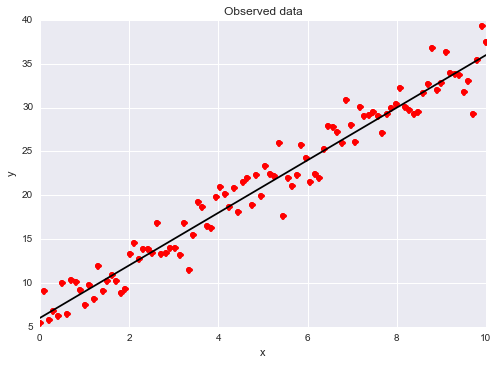

In [144]:
# Choose true params
a_true = 3
b_true = 6
sigma_true = 2
n = 100   # Length of data series

# For the independent variable, x, we will choose n values equally spaced
# between 0 and 10
x = np.linspace(0, 10, n)

# Calculate the dependent (observed) values, y
y = a_true*x + b_true + np.random.normal(loc=0, scale=sigma_true, size=n)

# Plot
plt.plot(x, y, 'ro')
plt.plot(x, a_true*x + b_true, 'k-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Observed data')
plt.show()

## 2. Frequentist linear regression

There are [several ways](https://en.wikipedia.org/wiki/Linear_regression#Least-squares_estimation_and_related_techniques) of performing simple linear regression, but the most commonly used is the OLS approach, which minimises the sum of squared model residuals. OLS regrssion under the assumption of **independent and identically distributed (iid) Gaussian errors** is so widely used that many software packages make the analysis very easy - so easy, in fact, that people often forget to **check** whether the iid assumption has actually been satisfied. In the examples below we won't check either, but that's because we *know* our test data was generated using iid errors, so we don't need to.

### 2.1. Fit the model

We'll use `statsmodels` to perform the regression in Python, including estimating 95% **confidence intervals** for the slope and intercept ($a$ and $b$, respectively). We must also estimate the error standard deviation , $\sigma_\epsilon$ (we'll ignore the confidence interval for this for now, because it's not provided by `statsmodels` by default).

In [145]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Add intercept for model
X = sm.add_constant(x)

# Fit
model = sm.OLS(y,X)
result = model.fit()

# Regression summary
print result.summary()
print '\n'

# Key results as dataframe
freq_df = pd.DataFrame(data={'a_freq':[result.conf_int()[1,0], 
                                       result.params[1], 
                                       result.conf_int()[1,1]],
                             'b_freq':[result.conf_int()[0,0], 
                                       result.params[0], 
                                       result.conf_int()[0,1]],
                             'sigma_freq':[np.nan, 
                                           (result.scale)**0.5, 
                                           np.nan]},
                       index=['2.5%', '50%', '97.5%'])
print freq_df.T

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     2066.
Date:                Sat, 07 Nov 2015   Prob (F-statistic):           1.14e-67
Time:                        20:14:14   Log-Likelihood:                -206.23
No. Observations:                 100   AIC:                             416.5
Df Residuals:                      98   BIC:                             421.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1723      0.382     16.176      0.0

### 2.2. Plot the result

We can now plot the **median** regression line plus the **95% confidence interval** around it.

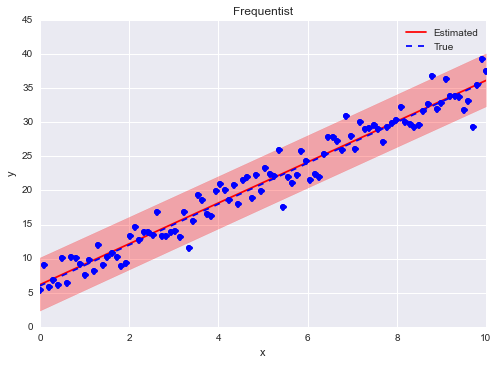

In [146]:
# Plot predicted
prstd, low, up = wls_prediction_std(result, alpha=0.05) # 95% interval
plt.fill_between(x, low, up, color='r', alpha=0.3)
plt.plot(x, result.fittedvalues, 'r-', label='Estimated')
plt.title('Frequentist')

# Plot true
plt.plot(x, y, 'bo')
plt.plot(x, a_true*x+b_true, 'b--', label='True')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')

The estimated "best-fit" line is very close to the true one. Also, if our 95% confidence interval is correct, we should expect roughly 95% of the observations to lie within the shaded area. This proportion is often called the "**coverage**".

### 2.3. Estimate coverage

In [147]:
# Data frame of lower CI, upper CI and observations
cov_df = pd.DataFrame({'low':low,
                       'obs':y,
                       'up':up})

# Are obs within CI?
cov_df['In_CI'] = ((cov_df['low'] < cov_df['obs']) & 
                   (cov_df['up'] > cov_df['obs']))

# Coverage
cov = 100.*cov_df['In_CI'].sum()/len(cov_df)

print 'Coverage: %.1f%%' % cov

Coverage: 95.0%


The coverage from the frequentist approach is correct, as expected.

## 3. Bayesian linear regression

For this problem, the Bayesian approach is significantly more complicated than the frequentist one. One of the real benefits of the Bayesian method, though, is its generality i.e. it doesn't necessarily become any more complicated when applied to challenging problems. As demonstrated in notebooks [4](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/04_MCMC.ipynb) and [6](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/06_Beyond_Metropolis.ipynb), the Bayesian approach is essentially the same regardless of whether you're performing simple linear regression or calibrating a hydrological model. It's worth bearing this in mind when working though the following sections.

### 3.1. Define the likelihood, prior and posterior

The likelihood, prior and posterior are defined in exactly the same way as in [section 7 of notebook 4](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/04_MCMC.ipynb#7.-Putting-it-all-together). Note that for the likelihood function we're required to explicitly define an **error structure**. This was not necessary for the frequentist approach above because `statsmodels.api.OLS` implicitly assumes iid Gaussian errors. For more complex error schemes, we'd need to specify the error struture for the frequentist analysis too.

In [148]:
from scipy.stats import norm

def log_likelihood(params, x, obs):
    """ Calculate log likelihood assuming iid Gaussian errors.
    """    
    # Extract parameter values
    a_est, b_est, sigma_est = params
    
    # Calculate deterministic results with these parameters
    sim = a_est*x + b_est
    
    # Calculate log likelihood
    ll = np.sum(norm(sim, sigma_est).logpdf(obs))
        
    return ll

def log_prior(params):
    """ Calculate log prior.
    """   
    # Extract parameter values
    a_est, b_est, sigma_est = params
    
    # If all parameters are within allowed ranges, return a constant 
    # (anything will do - I've used 0 here)
    if ((a_min <= a_est < a_max) and 
        (b_min <= b_est < b_max) and 
        (sigma_min <= sigma_est < sigma_max)):
        return 0
    # Else the parameter set is invalid (probability = 0; log prob = -inf)
    else:
        return -np.inf

def log_posterior(params, x, obs):
    """ Calculate log posterior.
    """  
    # Get log prior prob
    log_pri = log_prior(params)

    # Evaluate log likelihood if necessary
    if np.isfinite(log_pri):
        log_like = log_likelihood(params, x, obs)
        
        # Calculate log posterior
        return log_pri + log_like
    
    else:
        # Log prior is -inf, so log posterior is -inf too
        return -np.inf

### 3.2. Define limits for uniform priors

In the `log_prior` function above we've assumed **[improper uniform priors](https://en.wikipedia.org/wiki/Prior_probability#Improper_priors)**, just as we have in all the previous notebooks. Below we set allowable prior ranges for $a$, $b$ and $\sigma_\epsilon$.

In [149]:
a_min, a_max = -10, 10
b_min, b_max = -10, 10
sigma_min, sigma_max = 0, 10

### 3.3. Find the MAP

The [MAP](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) is the maximum of the posterior distribution. It gives the most likely values for the model parameters ($a$, $b$ and $\sigma_\epsilon$) *given our piors and the data*. It also provides a good starting point for our MCMC analysis.

In [150]:
from scipy import optimize

def neg_log_posterior(params, x, obs):
    """ Negative of log posterior.
    """
    return -log_posterior(params, x, obs)

def find_map(init_guess, x, obs):
    """ Find max of posterior.
        init_guess [a, b, sigma]
    """
    # Run optimiser
    param_est = optimize.fmin(neg_log_posterior, 
                              init_guess, 
                              args=(x, obs))

    return param_est

# Guess some starting values for [a, b, sigma]
param_guess = [1, 1, 1]

# Run optimiser
param_est = find_map(param_guess, x, y)

# Print results
print '\n'
for idx, param in enumerate(['a', 'b', 'sigma',]):
    print 'Estimated %s: %.2f.' % (param, param_est[idx])

Optimization terminated successfully.
         Current function value: 206.230122
         Iterations: 162
         Function evaluations: 295


Estimated a: 3.00.
Estimated b: 6.17.
Estimated sigma: 1.90.


It's reassuring to see the MAP estimates are close to the true values. However, as we've discusssed previously, these numbers are't much use without an indication of **uncertainty** i.e. how well-constrained are these values, given our priors and the data? For a simple problem like this, there are much simpler ways of estimating uncertainty using a Bayesian approach than by running an MCMC analysis (see [notebook 8](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/08_Gaussian_Approx.ipynb), for example). Nevertheless, the MCMC approach is very general and we've used it a number of times previously, so for consistency we'll apply it here as well.

### 3.4. Run the MCMC

As before, we'll use [emcee](http://dan.iel.fm/emcee/current/) to draw samples from the posterior.



Average acceptance fraction:  0.6815
Autocorrelation time:  [ 20.51629294  36.9195641    3.85606414]


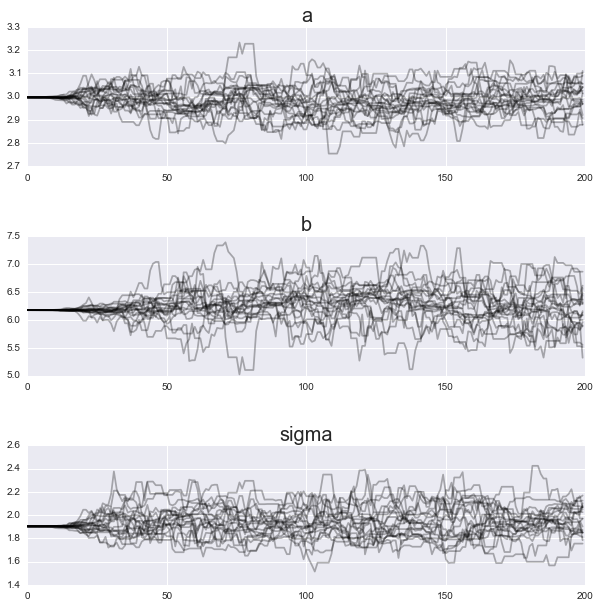

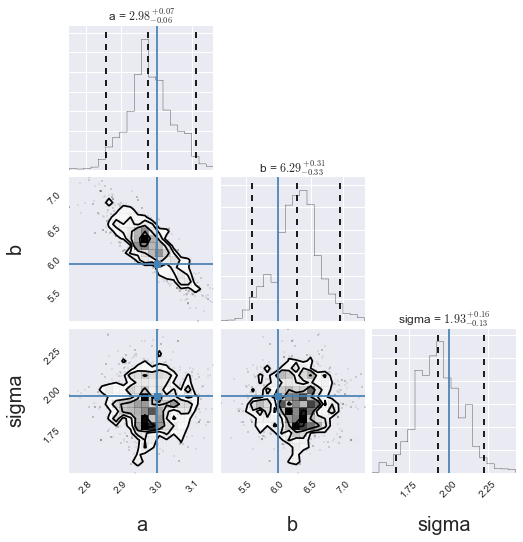

In [151]:
import emcee, corner

# emcee parameters
n_dim = 3      # Number of parameters being calibrated
n_walk = 20    # Number of "walkers"/chains
n_steps = 200  # Number of steps per chain
n_burn = 100   # Length of burn-in to discard

def run_mcmc(n_dim, n_walk, n_steps, n_burn, param_opt, truths=None):
    """ Sample posterior using emcee.
    
            n_dim      Number of parameters being calibrated
            n_walk     Number of walkers/chains (must be even)
            n_steps    Number of steps taken by each walker
            n_burn     Number of steps to discard as "burn-in"
            param_opt  Optimised parameter set from find_map()
            truths     True values (if known) for plotting
        
        Produces plots of the chains and a 'corner plot' of the
        marginal posterior distribution.
        
        Returns an array of samples (with the burn-in discarded).
    """
    # Generate starting locations for the chains by adding a small
    # amount of Gaussian noise to optimised MAP
    starting_guesses = [param_opt + 1e-4*np.random.randn(n_dim) 
                        for i in range(n_walk)]

    # Prepare to sample. The params are automatically passed to log_posterior
    # as part of n_dim. "args" lists the other params that are also necessary
    sampler = emcee.EnsembleSampler(n_walk, n_dim, log_posterior, 
                                    args=[x, y])

    # Run sampler
    pos, prob, state = sampler.run_mcmc(starting_guesses, n_steps)

    # Print some stats. based on run properties
    print '\n'
    print 'Average acceptance fraction: ', np.mean(sampler.acceptance_fraction)
    print 'Autocorrelation time: ', sampler.acor

    # Get results
    # Plot traces, including burn-in
    param_labels = ['a', 'b', 'sigma']
    fig, axes = plt.subplots(nrows=n_dim, ncols=1, figsize=(10, 10))    
    for idx, title in enumerate(param_labels):        
        axes[idx].plot(sampler.chain[:,:,idx].T, '-', color='k', alpha=0.3)
        axes[idx].set_title(title, fontsize=20) 
    plt.subplots_adjust(hspace=0.5)    
    plt.show()

    # Discard burn-in
    samples = sampler.chain[:, n_burn:, :].reshape((-1, n_dim))

    # Triangle plot
    tri = corner.corner(samples,
                        labels=param_labels,
                        truths=truths,
                        quantiles=[0.025, 0.5, 0.975],
                        show_titles=True, 
                        title_args={'fontsize': 24},
                        label_kwargs={'fontsize': 20})

    return samples

samples = run_mcmc(n_dim, n_walk, n_steps, n_burn, param_est, 
                   [a_true, b_true, sigma_true])

Blue solid lines on the "corner plot" above indicate the true values, while the vertical dotted lines on the histograms mark the 2.5%, 50% and 97.5% quantiles for the parameter estimates. In all cases, the true values lie well within the 95% **credible intervals** (a "credible interval" is the Bayesian equivalent of a frequentist "confidence interval").

### 3.6. Get the confidence intervals

As with the frequentist analysis, we can also plot our median simulation and the 95% credible interval on top of the observed data. First, we'll extract some key values into a data frame that we can compare with the frequentist results.

In [152]:
# Print estimates and confidence intervals
mcmc_df = pd.DataFrame(data=samples, columns=['a_mcmc', 'b_mcmc', 'sigma_mcmc'])
print mcmc_df.describe(percentiles=[0.025, 0.5, 0.975]).ix[['2.5%', '50%', '97.5%']].T

print '\n'
print freq_df.T

                2.5%       50%     97.5%
a_mcmc      2.857336  2.977162  3.109976
b_mcmc      5.594186  6.292076  6.954500
sigma_mcmc  1.667850  1.933849  2.220527


                2.5%       50%     97.5%
a_freq      2.865716  2.996540  3.127364
b_freq      5.415049  6.172266  6.929484
sigma_freq       NaN  1.922188       NaN


The Bayesian and frequentist results are very similar. We can also sample from our MCMC simulations to derive credible intervals for plotting.

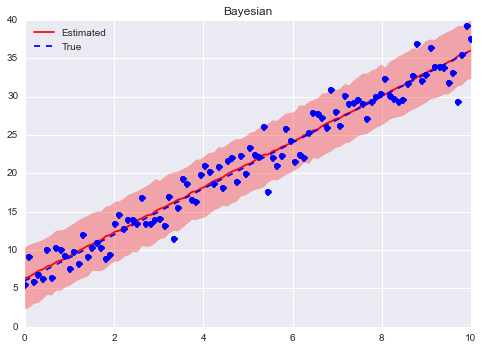

In [153]:
# Store output data in lists
conf = []

# Pick parameter sets at random from the converged chains
for a, b, sigma in samples[np.random.randint(len(samples), size=1000)]:
    # Simulate values
    sim = a*x + b + norm.rvs(loc=0, scale=sigma, size=n)
    
    df = pd.DataFrame(data={'Sim':sim})
    
    # Add to conf
    conf.append(df)

# Concatenate results
conf = pd.concat(conf, axis=1)

# Get 2.5 and 97.5 percentiles for plotting
conf = conf.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]

# Plot predicted
plt.fill_between(x, conf['2.5%'], conf['97.5%'], color='r', alpha=0.3)
plt.plot(x, conf['50%'], 'r-', label='Estimated')
plt.title('Bayesian')

# Plot true line
plt.plot(x, y, 'bo')
plt.plot(x, a_true*x+b_true, 'b--', label='True')

plt.legend(loc='best')

plt.show()

The edges of the **credible interval** are a little jagged due to our limited numerical sampling, but if we ran the chains for longer and used more samples to construct the intervals, we could get a smoother result. Nonetheless, it's pretty obvious that this interval is essentially identical to the one from the frequentist analysis. 

### 3.7. Get the coverage

As above, we can also calculate the coverage, which should be roughly 95%.

In [154]:
# Add observations to df
conf['obs'] = y

# Are obs within CI?
conf['In_CI'] = ((conf['2.5%'] < conf['obs']) & 
                 (conf['97.5%'] > conf['obs']))

# Coverage
cov = 100.*conf['In_CI'].sum()/len(conf)

print 'Coverage: %.1f%%' % cov

Coverage: 96.0%


## 4. GLUE

The GLUE methodology is a little different. First of all, GLUE typically makes use of **informal** or **pseudo-** likelihood functions, which do not explicitly consider the error structure between the model output and the observations. Within the GLUE framework, it is permissable to use *any* scoring metric (or combination of metrics) to evaluate model performance, with the emphasis focusing less on what is *statistically rigorous* and more on what is *physically meaningful*. For example, it is very common to see GLUE analyses using the **[Nash-Sutcliffe efficiency](https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient)** as an indcator of model performance. GLUE also takes what is often called a "limits of acceptability" approach, requiring the user to define a threshold for their chosen metric that distinguishes between **plausible** and **implausible** model simulations.

The methodology usually goes something like this:

  1. Choose a metric (or metrics) to indicate model performance. **Skill scores** such as Nash-Sutcliffe are very commonly used. <br><br>
  
  2. Set a threshold for the chosen skill score above which model simulations will be deemed to be plausible. These plausible simulations are usually termed "**behavioural**" within the GLUE framework. <br><br>
  
  3. Define prior distributions for the model's parameters. These are usually (but not necessarily) taken to be uniform, just like the ones we used above for the Bayesian analsysis. <br><br>
  
  4. Sample from the **pseudo-posterior**
  
  $$P_p(\theta|D) \propto P_p(D|\theta)P(\theta)$$
  
  where the likelihood term is replaced by the **pseudo-likelihood**. Just like the Bayesian approach, the sampling strategy can be any of those described in previous notebooks (e.g. Monte Carlo, MCMC etc.). However, the vast majority of GLUE analyses make use of **simple Monte Carlo sampling** i.e. draw a large random sample from the prior, then evaluate the pseudo-likelihood for each parameter set. <br><br>
  
  5. Any parameter sets scoring below the threshold defined in step 2 are **discarded**; those scoring above the threshold are labelled "**behavioural**" and kept for further analysis. <br><br>
  
  6. The behavioural parameter sets are **weighted** according to their skill score. The model simulations are then ranked from lowest to highest, and the normalised weights are accumulated to produce a **[cumulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function)**. <br><br>
  
  7. The CDF is used to define a 95% **uncertainty interval** or **prediction limit** for the model output.

Some key points to note are that:

  1. The use of a pseudo-likelihood function means the pseudo-posterior is not a true probability distribution, so GLUE **cannot** be used to generate a **marginal posterior distribution** for each model parameter. The basic unit of consideration in GLUE is the parameter **set**. <br><br>  
  
  2. The prediction limits (or uncertainty intervals) identified by GLUE are **subjective** and have **no clear statistical meaning**. For example, they are **not** confidence bounds in any true statistical sense: the 95% confidence interval is *not* expected to include 95% of the observations.
  
We will discuss the strengths and limitations of GLUE below, but first we'll apply the method to solve our simple linear regression problem.

### 4.1. Define the pseudo-likelihood

The range of possible metrics for the pseudo-likelihood is huge. In this example we'll use the **Nash-Sutcliffe efficiency**, which is very commonly used wth GLUE. Note that other metrics may perform better (see below), but a key "selling point" of the GLUE approach is that we shouldn't have to worry too much about our choice of goodness-of-fit measure.

In [155]:
def nash_sutcliffe(params, x, obs):
    """ Nash-Sutcliffe efficiency.
    """
    # Extract parameter values
    a_est, b_est = params
    
    # Run simulation
    sim = a_est*x + b_est
    
    # NS
    num = np.sum((sim - obs)**2)
    denom = np.sum((obs - obs.mean())**2)
    ns = 1 - (num/denom)
    
    return [ns, sim]

### 4.2. Set the behavioural threshold and sample size

We next need to set a **behavioural threshold** to separate plausible from implausible parameter sets. Choosing an appropriate threshold can be difficult, as it is rare for our skill score to have any direct physical relevance for our problem of interest (i.e. what is a "good" Nash-Sutcliffe score in the context of linear regression? What about for hydrology? etc.). 

If we set our threshold too high, we will identify very few behavioural parameter sets; set it too low, and we risk classifying some poor simulations as "behavioural" and biasing our results. In practice, many published studies start off with a stringent behavioural threshold, but are then forced to relax it in order to find enough behavioural parameter sets to continue the analysis. This is sometimes argued to be an advantage, in the sense that GLUE allows rejection of **all** available models if none of them meet the pre-defined performance criteria.

For now, we'll try a threshold of $0.7$ and we'll investigate the effects of changing it later.

We also need to decide how many samples to draw from our prior. For this simple 2D example, Monte Carlo sampling should actually work OK, so we'll choose the same total number of samples as we used above in our MCMC analysis. Note, however, that for problems in a larger parameter space, we might need to draw a *very* large number of samples indeed using Monte Carlo methods to get a reasonable representation of the posterior.

In [156]:
ns_min = 0.7
n_samp = 4000

### 4.3. Sample from the prior

One of the main advantages of Monte Carlo GLUE is that it is usually very easy to code (and to parallelise). Here we're drawing 4000 independent samples from our priors.

In [157]:
a_s = np.random.uniform(low=a_min, high=a_max, size=n_samp)
b_s = np.random.uniform(low=b_min, high=b_max, size=n_samp)

### 4.4. Run GLUE

For each of the parameter sets drawn above, we run the model and calculate the Nash-Sutcliffe efficiency. If it's above the behavioural threshold we'll store that parameter set and the associated model output, otherwise we'll discard both.

In [158]:
def run_glue(a_s, b_s, n_samp, ns_min):
    """ Run GLUE analysis.
        Uses nash_sutcliffe() to estimate performance and returns
        dataframes containing all "behavioural" parameter sets and
        associated model output.
    """
    # Store output
    out_params = []
    out_sims = []

    # Loop over param sets
    for idx in range(n_samp):
        params = [a_s[idx], b_s[idx]]

        # Calculate Nash-Sutcliffe
        ns, sim = nash_sutcliffe(params, x, y)

        # Store if "behavioural"
        if ns >= ns_min:
            params.append(ns)
            out_params.append(params)
            out_sims.append(sim)

    # Build df
    params_df = pd.DataFrame(data=out_params, 
                             columns=['a', 'b', 'ns'])

    assert len(params_df) > 0, 'No behavioural parameter sets found.'

    # Number of behavioural sets
    print 'Found %s behavioural sets out of %s runs.' % (len(params_df), n_samp)

    # DF of behavioural simulations
    sims_df = pd.DataFrame(data=out_sims)
    
    return params_df, sims_df

params_df, sims_df = run_glue(a_s, b_s, n_samp, ns_min)

Found 163 behavioural sets out of 4000 runs.


Note that with a two dimensional parameter space and Nash-Sutcliffe cut-off of $0.7$, only about $\frac{1}{20}th$ of the model runs are classified as "behavioural". This fraction would decrease *very rapidly* if the parameter space became larger.

### 4.5. Estimate confidence intervals

Using just the behavioural parameter sets, we **rank** the model output and calculate **weighted quantiles** to produce the desired CDF.

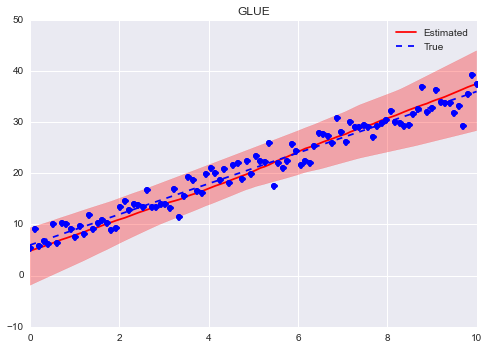

In [159]:
def weighted_quantiles(values, quantiles, sample_weight=None):
    """ Modified from 
        http://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy     
        NOTE: quantiles should be in [0, 1]
        
        values         array with data
        quantiles      array with desired quantiles
        sample_weight  array of weights (the same length as `values`)

        Returns array with computed quantiles.
    """
    # Convert to arrays
    values = np.array(values)
    quantiles = np.array(quantiles)
    
    # Assign equal weights if necessary
    if sample_weight is None:
        sample_weight = np.ones(len(values))
        
    # Otherwise use specified weights
    sample_weight = np.array(sample_weight)
    
    # Check quantiles specified OK
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    # Sort 
    sorter = np.argsort(values)
    values = values[sorter]
    sample_weight = sample_weight[sorter]

    # Compute weighted quantiles
    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    weighted_quantiles /= np.sum(sample_weight)
    
    return np.interp(quantiles, weighted_quantiles, values)

def plot_glue(params_df, sims_df):
    """ Plot median simulation and confidence intervals for GLUE.
    """
    # Get weighted quantiles for each point in x from behavioural simulations
    weights = params_df['ns']
    quants = [0.025, 0.5, 0.975]

    # List to store output
    out = []

    # Loop over points in x
    for col in sims_df.columns:
        values = sims_df[col]
        out.append(weighted_quantiles(values, quants, sample_weight=weights))

    # Build df
    glue_df = pd.DataFrame(data=out, columns=['2.5%', '50%', '97.5%'])

    # Plot predicted
    plt.fill_between(x, glue_df['2.5%'], glue_df['97.5%'], color='r', alpha=0.3)
    plt.plot(x, glue_df['50%'], 'r-', label='Estimated')
    plt.title('GLUE')

    # Plot true line
    plt.plot(x, y, 'bo')
    plt.plot(x, a_true*x+b_true, 'b--', label='True')

    plt.legend(loc='best')

    plt.show()
    
    return glue_df
    
glue_df = plot_glue(params_df, sims_df)

These results are clearly a bit different to the output from the Bayesian and frequentist analyses presented above. The predicted line is not as good a fit to the true data and the confidence interval is wider at the extremes than it is towards the middle. Nevertheless, this result seems superficially reasonable in the sense that it does not obviously contradict the output obtained from the other methods. Overall it is likely that, in a decision-making context, all these approaches would lead to broadly the same actions being taken.

### 4.6. Coverage

For consistency, we'll also calculate the coverage for GLUE, but note that *GLUE confidence intervals are not expected to bracket the stated proportion of the observations* (see above).

In [160]:
def glue_coverage(glue_df):
    """ Prints coverage from GLUE analysis.
    """
    # Add observations to df
    glue_df['obs'] = y

    # Are obs within CI?
    glue_df['In_CI'] = ((glue_df['2.5%'] < glue_df['obs']) & 
                        (glue_df['97.5%'] > glue_df['obs']))

    # Coverage
    cov = 100.*glue_df['In_CI'].sum()/len(glue_df)

    print 'Coverage: %.1f%%' % cov
    
glue_coverage(glue_df)

Coverage: 98.0%


Based on the results so far, you might be thinking there's not much to choose between any of these approaches, but let's see what happens to the GLUE output if the behavioural threshold is adjusted.

### 4.7. Changing the behavioural threshold

The Nash-Sutlcliffe score can take any value from $-\infty$ to $1$, with $0$ implying the model output is no better than taking the **mean** of the observations. What happens if we **relax the behavioural threshold** by setting it to $0$?

Found 509 behavioural sets out of 4000 runs.


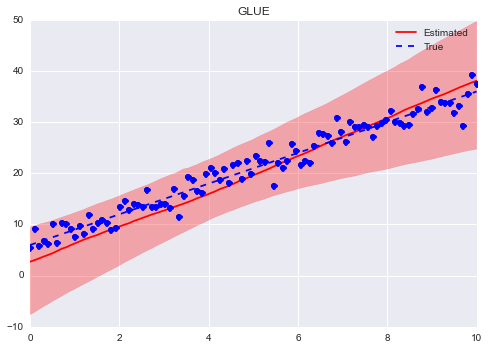

Coverage: 100.0%


In [161]:
ns_min = 0

params_df, sims_df = run_glue(a_s, b_s, n_samp, ns_min)

glue_df = plot_glue(params_df, sims_df)

glue_coverage(glue_df)

And what if we **make the behavioural threshold more stringent**, by setting it to $0.9$?

Found 32 behavioural sets out of 4000 runs.


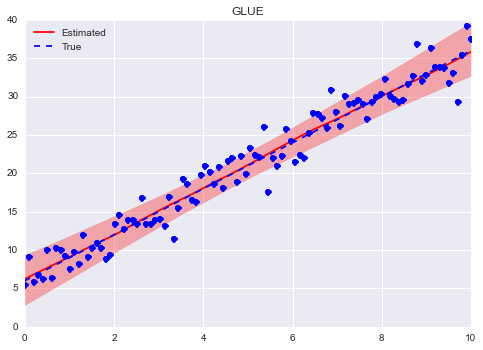

Coverage: 73.0%


In [162]:
ns_min = 0.9

params_df, sims_df = run_glue(a_s, b_s, n_samp, ns_min)

glue_df = plot_glue(params_df, sims_df)

glue_coverage(glue_df)

## 5. Interpretation

How should we interpret this very simple analysis? 

Just to reiterate from above, the confidence intervals derived from GLUE have no formal statistical meaning, so we should not be surprised to see the **GLUE 95% uncertainty interval** bracketing anything between about **70% and 100% of the data**. Nevertheless, you may be surprisied to see just how much the GLUE confidence bounds depend on the (arbitrary) choice of behavioural threshold. In essence, it seems we can set the uncertainty to be **almost anything we like**, just by tuning the cut-off. How, then, are we to interpret the uncertainty limits presented by GLUE from the point of view of **decision making**?

As a related question, it seems reasonable to ask, *"What's the point of a 95% uncertainty interval that has no intention of bracketing 95% of the data?"* Frequentist "confidence" and Bayesian "credible" intervals have a very widely accepted meaning in statistics, and it is rather confusing that GLUE presents something that looks so superficially similar, but which is actually nothing of the sort.

A further difficulty with GLUE concerns the method's ability to assimilate more data. If the above examples are repeated using a larger observed dataset, the confidence intervals for the parameter estimates from the Bayesian and frequentist analyses will become **narrower**. This is consistent with the (fairly fundamental) idea that more data provides more information, and therefore allows us to make more refined estimates. This is not necessarily the case with GLUE: as described in some detail by [Stedinger *et al.* (2008)](http://onlinelibrary.wiley.com/doi/10.1029/2008WR006822/abstract), predictions from GLUE do not necessarily become more refined as the amount of data increases.

## 6. Methodological inconsistency?

In addition to the issues mentioned above, there are a number of features of the GLUE methodology that are difficult to reconcile.

### 6.1. Limits of acceptability *and* likelihood weighting?

GLUE is often described as a "limits of acceptability" approach, because it defines a threshold below which parameers sets are discarded as being implausible. This is in contrast to more formal methods that use the likelihood function to weight *all* parameter sets, in such a way that poor sets are assigned lower weights then good ones. One strange thing about GLUE is that it implements a limits of acceptability threshold **as well as** weighting the behavioural sets according to the pseudo-likelihood.

If it is possibe to assign a physically meaningful limit of acceptability, then surely all the acceptable (i.e. behavioural) parameter sets should be assigned equal weight? (**Generalised Sensitivity Analysis**, a closely related technique to GLUE, does exactly this - see e.g. [Young, 1999](http://www.sciencedirect.com/science/article/pii/S0010465598001684)). On the other hand, if "acceptability" is better considered as a **continuous spectrum**, it would seem more sensible *not* to set a well-defined threshold and to weight each parameter set according to some continuous measure of performance, exactly as done in a formal Bayesian setting. Doing **both**, as is the case with GLUE, implies that the informal likelihood function cannot be trusted to distinguish between good and bad parameter sets.

[Stedinger *et al.* (2008)](http://onlinelibrary.wiley.com/doi/10.1029/2008WR006822/abstract) have demonstrated that, when used with a formal statistical likelihood, GLUE can produce results that are "correct" in a statistical sense. However, they also point out that when this is done the behavioural threshold becomes unnecessary, because the formal likelihood is capable of effectively separating good from bad simulations. Of course, GLUE with a formal likelihood and no limit of acceptability is **no longer GLUE** - it's simply a Monte Carlo-based formal Bayesian approach, similar to **[importance sampling](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/03_Monte_Carlo.ipynb#2.2.2.-Importance-sampling)**. Such formal Bayesian approaches pre-date GLUE by several decades and their limitations in high dimensional spaces are very well documented.

### 6.2. Fewer assumptions?

It is often claimed that GLUE makes "**fewer assumptions**" than more formal statistical approaches, because it is not necessary to explicitly specify and test any particular error structure. However, although GLUE may not require an explicit consderation of the errors, just because an issue is ignored does not mean it will go away. Commonly used pesudo-likelihoods for GLUE, such as the inverse error variance or the Nash-Sutcliffe efficiency, all make **implicit** assumptions about the nature of the error structure. In addition, many of these metrics have unintended or undesirable characteristics, such as not properly accounting for number of samples in the observational dataset (see section 5, above).

Choosing an arbitrary metric without understanding the assumptions inherent in that choice is not the same as making fewer assumptions - it's more a case of **acknowledging fewer assumptions**. 

## 7. Computational inefficiency

A less controversial but nonetheless significant drawback of the standard GLUE implementation is its **computational inefficiency**. Unlike concerns regarding statistical validity, there is really no debate to be had about sampling efficiency: standard Monte Carlo methods are expected to be *extremely inefficient* in high dimensional parameter spaces, and the standard Monte Carlo version of GLUE is no different (see [notebook 3](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/03_Monte_Carlo.ipynb) for a discussion of why this is the case). 

It is of course possibe to use GLUE with *any* sampling strategy. [Blasone *et al.* (2007)](http://www.sciencedirect.com/science/article/pii/S0309170807001856) implemented GLUE using an MCMC approach, which resulted in vastly improved sampling efficiency. This method has not become popular, however - perhaps because the most appealing aspects of GLUE are its conceptual simplicity and ease of coding compared to e.g. MCMC.

## 8. Is this comparison fair?

A common response from proponents of GLUE to comparisons of this kind is to say:

*"In the Bayesian example you used exactly the right likelihood function, so of course you got better results. If you'd used the correct likelihood function with GLUE, GLUE would have worked better too. In reality, though, you never know what the true likelihood is."*

This is a fair comment in some respects: GLUE *can* produce more reasonable answers when used with a formal likelihood function. [Beven *et al.* (2007)](http://www.sciencedirect.com/science/article/pii/S0022169407001230) have even argued that, *"the formal Bayesian identification of models is a special case of GLUE"*. This statement is difficult to accept, at least in part because two of the key characteristics of GLUE are:

  1. The use of an **informal likelihood** and <br><br>
  
  2. The setting of a **behavioural** threshold.
  
As noted above, [Stedinger *et al.* (2008)](http://onlinelibrary.wiley.com/doi/10.1029/2008WR006822/abstract) have demonstrated that GLUE *can* perform correctly using a formal likelihood, but they also showed that this makes the behavioural threshold redundant, in which case the method is just a very outdated formal Bayesian approach - one that can **no longer reasonably be called "GLUE"**.

On the whole, the analysis presented here is consistent with the approaches recommended for the three different methods: Bayesian and frequentist analyses require us to think carefully about formulating an appropriate error structure and to test to see whether those assumptions have been met (refining them if necessary); GLUE, on the other hand, does not require any explicit consideration of the distribution of the residuals.

Of course, in the examples here we knew the exact form of the true likelihood and we used this to advantage in the Bayesian and frequentist analyses. An advocate of GLUE could argue that we never have this information in reality - which is true - but not knowing something doesn't mean we can just ignore the issue. What's more, it is perfectly possible to *test* whether the error assumptions in a formal analysis have been met, so although we never know the true likelihood for sure, we can at least say whether the data are consistent with what we've assumed. There are plenty of papers in the literature where the authors *do* achieve reasonable results using a formal statistical approach, so adopting an *ad hoc* methodology such as GLUE seems unjustified. What's more, using an informal likelihood function does not remove the problem of specifying an error structure - it simply hides the assumptions being made implicitly by whatever goodness-of-fit metric is selected.

Statistics would be a great deal easier if we could perform robust inference without having to think about things like likelihoods and error structures. GLUE is appealing partly because it **promises a great deal for very little effort**, which is attractive to environmental scientists bewildered by statistical notation and seemingly impenetrable mathematics. Unfortunately, I'm increasingly of the opinion that the claims made for GLUE are **too good to be true**, and I'm inclined to agree with [Stedinger *et al.* (2008)](http://onlinelibrary.wiley.com/doi/10.1029/2008WR006822/abstract) that,

*"If an arbitrary likelihood is adopted that does not reasonably reflect the sampling distribution of the model errors, then GLUE generates arbitrary results without statistical validity that should not be used in scientific work."*

Don't take my word for it, though - please read the papers cited here (and elsewhere) and **make up your own mind**.